In [2]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
import subprocess

In [ ]:
def run_python_script(args, cwd=None):
    """
    Executes a Python script with the given arguments list in the specified directory.
    Prints STDOUT in real time.
    The first element should be the script path, followed by its arguments.
    Example: ["other_script.py", "--foo", "bar"]
    """
    cmd = ["python"] + args
    print("Running command:", " ".join(cmd))
    process = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        cwd=cwd
    )

    while True:
        stdout_line = process.stdout.readline()
        if stdout_line:
            print(stdout_line, end="", flush=True)
        elif process.poll() is not None:
            break

    for line in process.stdout:
        print(line, end="", flush=True)

    stderr = process.stderr.read()
    if stderr:
        print("\n--- STDERR ---\n", stderr)

    process.stdout.close()
    process.stderr.close()
    return process

    

In [ ]:
args = ["./train_classifiers_over_subsamples.py"]
run_python_script(args, cwd=os.path.abspath("./"))

In [24]:
subsamples_dir = "data/subsamples"
files = os.listdir(subsamples_dir)

files = [f for f in files if f.startswith("n_") and f.endswith(".csv")]

import pandas as pd


df_list = []
for file in files:
    file_path = os.path.join(subsamples_dir, file)
    df = pd.read_csv(file_path)
    df["source_file"] = file  
    if "ohe" in file:
        df["model"] = "ohe"
    elif "llm" in file:
        df["model"] = "esm"

    df_list.append(df)

all_data = pd.concat(df_list, ignore_index=True)
all_data

,tp,tn,fp,fn,precision,recall,f1,accuracy,roc,top_100_pct,fraction,iter,source_file,model
0,9338,429270,10152,22275,0.479117,0.295385,0.365458,0.931158,0.787164,1.00,0.1,0,n_across_iterations_llm_fraction_0.1000.csv,esm
1,9671,427343,12133,21888,0.443542,0.306442,0.362461,0.927774,0.766998,0.96,0.1,1,n_across_iterations_llm_fraction_0.1000.csv,esm
2,9127,428201,11269,22438,0.447490,0.289149,0.351302,0.928441,0.772095,0.98,0.1,2,n_across_iterations_llm_fraction_0.1000.csv,esm
3,9534,430792,8627,22082,0.524971,0.301556,0.383068,0.934805,0.787387,0.99,0.1,3,n_across_iterations_llm_fraction_0.1000.csv,esm
4,8695,428938,10426,22976,0.454736,0.274541,0.342377,0.929088,0.757846,0.93,0.1,4,n_across_iterations_llm_fraction_0.1000.csv,esm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,17877,433728,5679,13751,0.758915,0.565227,0.647905,0.958750,0.930950,1.00,0.1,5,n_across_iterations_ohe_fraction_0.1000.csv,ohe
156,18048,433631,5841,13515,0.755494,0.571809,0.650941,0.958908,0.933008,1.00,0.1,6,n_across_iterations_ohe_fraction_0.1000.csv,ohe
157,18062,433521,5898,13554,0.753840,0.571293,0.649993,0.958704,0.930669,1.00,0.1,7,n_across_iterations_ohe_fraction_0.1000.csv,ohe
158,17854,433815,5613,13753,0.760813,0.564875,0.648364,0.958886,0.932429,1.00,0.1,8,n_across_iterations_ohe_fraction_0.1000.csv,ohe


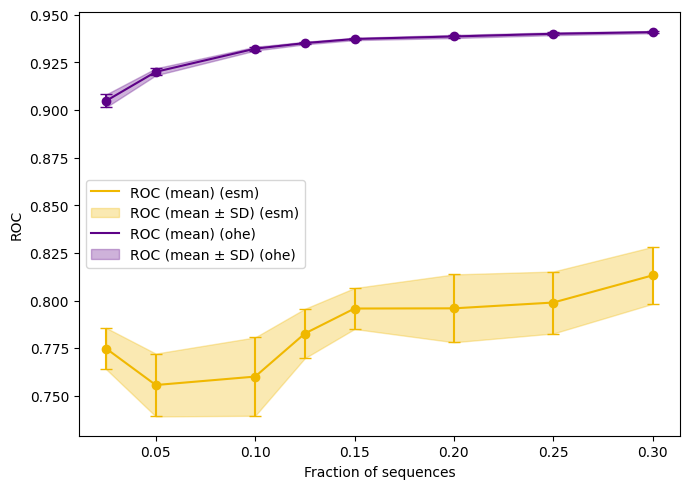

In [32]:

grouped = (
    all_data.groupby(["fraction", "model"])["roc"]
    .agg(["mean", "std"])
    .reset_index()
)

# For a ribbon plot (mean ± std) with error bars for each model
plt.figure(figsize=(7, 5))
colors = {"ohe": "#5d0187", "esm": "#f0b800"}

for model in grouped["model"].unique():
    data = grouped[grouped["model"] == model]
    plt.plot(
        data["fraction"], data["mean"], label=f"ROC (mean) ({model})", color=colors.get(model, None)
    )
    plt.fill_between(
        data["fraction"],
        data["mean"] - data["std"],
        data["mean"] + data["std"],
        color=colors.get(model, None), alpha=0.3, label=f"ROC (mean ± SD) ({model})"
    )
    plt.errorbar(
        data["fraction"], data["mean"], yerr=data["std"], fmt='o', color=colors.get(model, None), capsize=4
    )

plt.xlabel("Fraction of sequences")
plt.ylabel("ROC")
#plt.title("F1 Score across Fractions by Model (mean ± std)")
plt.legend()
plt.tight_layout()
plt.show()

